from skimage import io, transform, exposure, color, util
import os, itertools, sys
from PIL import Image
%pylab inline
sys.setrecursionlimit(1000000)

In [2]:
# data_dir = "/home/dylan/IdeaProjects/distracted_drivers/train/"
data_dir =  "/media/dylan/Science/Kaggle-Data/distracted_drivers/train/"

In [3]:
input_volume_shape = (128, 128)

In [4]:
def read_img_file_PIL(file_path, size=(32,32)):
    img = Image.open(file_path).convert('L')
    img.thumbnail(size, Image.NEAREST)
    data = np.array(img)
    shape = data.shape
    append_top = int(ceil(max(0, size[0] - shape[0])/2.0))
    append_bot = int(floor(max(0, size[0] - shape[0])/2.0))
    data = util.pad(data, ((append_top, append_bot),
                           (0,0)), mode='constant', constant_values=0)
    return data

In [5]:
def read_img_file(file_path, rescale=0.01):
    img = io.imread(file_path)
    img= color.rgb2gray(img)
    return transform.rescale(img, rescale)

In [6]:
def image_gen_from_dir(directory, batch_size, num_categories, size=input_volume_shape):
    result = {os.path.join(dp, f) : int(os.path.split(dp)[1]) for dp, dn, filenames in os.walk(data_dir) 
                  for f in filenames if os.path.splitext(f)[1] == '.jpg'}
    # infinite loop
    while True:
        image_files = []
        labels = []
        # randomly choose batch size samples in result
        for category in range(num_categories):
            file_samples = np.random.choice([k for k, v in result.iteritems() if v == category], 
                             size=batch_size, replace=False)
            for file_sample in file_samples:
                image_files.append(read_img_file_PIL(file_sample, size=size))
            labels.extend([v for v in itertools.repeat(category, batch_size)])

        # end category loop
        X = np.asarray(image_files, dtype=np.float32)
        # -1 to 1 range
        X = exposure.rescale_intensity(X, out_range=(-1,1))
        y = np.asarray(labels, dtype=np.int32)
        yield X, y

## Another loader, augmentation time

We'll do 6 augmentations:


    1.) Translation up to 10 pixels
    2.) Rotation up to 15 degrees
    3.) Zooming
    4.) JPEG compression
    5.) Sharpening
    6.) Gamma correction


We won't do flips since the dataset only contains images from the passenger seat. Perhaps we can revisit this later.

In [7]:
from skimage.transform import rotate, warp, AffineTransform
from skimage import filters
from scipy import ndimage, misc
import StringIO

In [8]:
def random_translate(img):
    shift_random = AffineTransform(translation=(randint(-10, 10), randint(-10, 10)))
    min_value = 0 if min(img.ravel()) > 0 else min(img.ravel())
    return np.float32(warp(img, shift_random, mode='constant', cval=min_value))

def random_rotate(img):
    min_value = 0 if min(img.ravel()) > 0 else min(img.ravel())
    return np.float32(rotate(img, randint(-15, 15), mode='constant', cval=min_value))

def random_zoom(img):
    min_value = 0 if min(img.ravel()) > 0 else min(img.ravel())
    scale_random = AffineTransform(scale=(uniform(0.9, 1.1), uniform(0.9, 1.1)))
    return np.float32(warp(img, scale_random, mode='constant', cval=min_value))

def random_compress(img):
    max_v = np.ceil(img.max())
    min_v = np.floor(img.min())
    nd_im = exposure.rescale_intensity(img, out_range=(0, 1)).squeeze()
    nd_im = np.ndarray.astype(nd_im * 255, np.uint8)
    # nd_im = np.ndarray.astype(img * 255, np.uint8)
    im = Image.fromarray(nd_im)
    buf = StringIO.StringIO()
    im.save(buf, "JPEG", quality=np.random.randint(95, 99))
    buf.seek(0)
    im2 = Image.open(buf)
    x1 = exposure.rescale_intensity(np.ndarray.astype(np.array(im2), np.float32), out_range=(min_v, max_v))
    return x1

def random_sharpening(img):
    blurred_f = ndimage.gaussian_filter(img, 0.5)
    filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    alpha = uniform(0.9, 1.2)
    img = blurred_f + alpha * (blurred_f - filter_blurred_f)
    return exposure.rescale_intensity(img, out_range=(-1 , 1))

def random_gamma_correction(img):
    max_v = np.ceil(img.max())
    min_v = np.floor(img.min())
    img = exposure.rescale_intensity(img, out_range=(0,1))
    img = exposure.adjust_gamma(img, uniform(0.2, 0.8))
    return exposure.rescale_intensity(img, out_range=(-1, 1))

In [9]:
def random_aug(img):
    choice = np.random.randint(0,6)
    # choose from 4 different augmentations!
    if choice == 0:
        return random_translate(img)
    elif choice == 1:
        return random_rotate(img)
    elif choice == 2:
        return random_zoom(img)
    elif choice == 3:
        return random_compress(img)
    elif choice == 4:
        return random_sharpening(img)
    else:
        return random_gamma_correction(img)

In [10]:
def random_aug_batch(X, aug_algorithm):
    for i in range(X.shape[0]):
        X[i] = aug_algorithm(X[i])
    return X

In [11]:
def random_aug_gen(gen, aug_algorithm):
    for batchX, batchY in gen:
        yield random_aug_batch(batchX, aug_algorithm), batchY

# Process Generator with cached elements

In [12]:
def threaded_generator(generator, num_cached=50):
    import Queue
    queue = Queue.Queue(maxsize=num_cached)
    sentinel = object()  # guaranteed unique reference

    # define producer (putting items into queue)
    def producer():
        for item in generator:
            queue.put(item)
        queue.put(sentinel)

    # start producer (in a background thread)
    import threading
    thread = threading.Thread(target=producer)
    thread.daemon = True
    thread.start()

    # run as consumer (read items from queue, in current thread)
    item = queue.get()
    while item is not sentinel:
        yield item
        queue.task_done()
        item = queue.get()

In [13]:
from nolearn.lasagne import NeuralNet
from lasagne.layers import DenseLayer, ReshapeLayer, Upscale2DLayer, Conv2DLayer, InputLayer, DropoutLayer, \
    MaxPool2DLayer, get_all_params, batch_norm
import numpy as np
from lasagne.nonlinearities import softmax, leaky_rectify
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo, objective
from nolearn.lasagne import TrainSplit
from common import EarlyStopping, EndTrainingFromEarlyStopping
from lasagne.objectives import categorical_crossentropy, aggregate
import cPickle as pickle
from sklearn import metrics
import time, logging, logging.config, logging.handlers

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, CuDNN 4004)


In [14]:
try:
    from lasagne.layers.dnn import Conv2DDNNLayer, MaxPool2DDNNLayer
    def conv_2_layer_stack(top, num_filters):
        conv1 = batch_norm(Conv2DDNNLayer(top, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv2 = batch_norm(Conv2DDNNLayer(conv1, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        return MaxPool2DDNNLayer(conv2, (2, 2), 2)
    
    def conv_4_layer_stack(top, num_filters):
        conv1 = batch_norm(Conv2DDNNLayer(top, num_filters, (3, 3), stride=1, pad=0, nonlinearity=leaky_rectify))
        conv2 = batch_norm(Conv2DDNNLayer(conv1, num_filters, (3, 3), stride=1, pad=0, nonlinearity=leaky_rectify))
        conv3 = batch_norm(Conv2DDNNLayer(conv2, num_filters, (3, 3), stride=1, pad=0, nonlinearity=leaky_rectify))
        conv4 = batch_norm(Conv2DDNNLayer(conv3, num_filters, (3, 3), stride=1, pad=0, nonlinearity=leaky_rectify))
        return MaxPool2DDNNLayer(conv4, (2, 2), 2)
    
    def conv_6_layer_stack(top, num_filters):
        conv1 = batch_norm(Conv2DDNNLayer(top, num_filters, (3, 3), stride=1, pad=1,   nonlinearity=leaky_rectify))
        conv2 = batch_norm(Conv2DDNNLayer(conv1, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv3 = batch_norm(Conv2DDNNLayer(conv2, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv4 = batch_norm(Conv2DDNNLayer(conv3, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv5 = batch_norm(Conv2DDNNLayer(conv4, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv6 = batch_norm(Conv2DDNNLayer(conv5, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        return MaxPool2DLayer(conv6, (2, 2), 2)
    
except ImportError:
    def conv_2_layer_stack(top, num_filters):
        conv1 = batch_norm(Conv2DLayer(top, num_filters, (3, 3), stride=1, pad=1,   nonlinearity=leaky_rectify))
        conv2 = batch_norm(Conv2DLayer(conv1, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        return MaxPool2DLayer(conv2, (2, 2), 2)
    
    def conv_4_layer_stack(top, num_filters):
        conv1 = batch_norm(Conv2DLayer(top, num_filters, (3, 3), stride=1, pad=0,   nonlinearity=leaky_rectify))
        conv2 = batch_norm(Conv2DLayer(conv1, num_filters, (3, 3), stride=1, pad=0, nonlinearity=leaky_rectify))
        conv3 = batch_norm(Conv2DLayer(conv2, num_filters, (3, 3), stride=1, pad=0, nonlinearity=leaky_rectify))
        conv4 = batch_norm(Conv2DLayer(conv3, num_filters, (3, 3), stride=1, pad=0, nonlinearity=leaky_rectify))
        return MaxPool2DLayer(conv4, (2, 2), 2)
    
    def conv_6_layer_stack(top, num_filters):
        conv1 = batch_norm(Conv2DLayer(top, num_filters, (3, 3), stride=1, pad=1,   nonlinearity=leaky_rectify))
        conv2 = batch_norm(Conv2DLayer(conv1, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv3 = batch_norm(Conv2DLayer(conv2, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv4 = batch_norm(Conv2DLayer(conv3, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv5 = batch_norm(Conv2DLayer(conv4, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        conv6 = batch_norm(Conv2DLayer(conv5, num_filters, (3, 3), stride=1, pad=1, nonlinearity=leaky_rectify))
        return MaxPool2DLayer(conv6, (2, 2), 2)

In [15]:
input_layer = InputLayer((None, 1, input_volume_shape[0], input_volume_shape[1]))
conv_stack_1 = conv_2_layer_stack(input_layer, 32)
conv_stack_2 = conv_2_layer_stack(conv_stack_1, 64)
conv_stack_3 = conv_4_layer_stack(conv_stack_2, 128)
conv_stack_4 = conv_4_layer_stack(conv_stack_3, 256)
dropout17 = DropoutLayer(conv_stack_4, p=0.5)
dense18 = DenseLayer(dropout17, 2048, nonlinearity=leaky_rectify)
dropout19 = DropoutLayer(dense18, p=0.5)
dense20 = DenseLayer(dropout19, 2048, nonlinearity=leaky_rectify)
softmax21 = DenseLayer(dense20, 10, nonlinearity=softmax)

## Quality of Life Functions

In [16]:
if not os.path.exists("logs"):
    os.mkdir("logs")
logging.config.fileConfig("logging-training.conf")

def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get layer weights except for the biases
    weights = get_all_params(layers[-1], regularizable=True)
    regularization_term = 0.0
    # sum of abs weights for L1 regularization
    if lambda1 != 0.0:
        sum_abs_weights = sum([abs(w).sum() for w in weights])
        regularization_term += (lambda1 * sum_abs_weights) 
    # sum of squares (sum(theta^2))
    if lambda2 != 0.0:
        sum_squared_weights = (1 / 2.0) * sum([(w ** 2).sum() for w in weights])
        regularization_term += (lambda2 * sum_squared_weights)
    # add weights to regular loss
    losses += regularization_term
    return losses

def eval_regularization(net):
    if net.objective_lambda1 == 0 and net.objective_lambda2 == 0:
        return 0
    # check the loss if the regularization term is not overpowering the loss
    weights = get_all_params(net.layers_[-1], regularizable=True)
    # sum of abs weights for L1 regularization
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squares (sum(theta^2))
    sum_squared_weights = (1 / 2.0) * sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    regularization_term = (net.objective_lambda1 * sum_abs_weights) \
                          + (net.objective_lambda2 * sum_squared_weights)
    return regularization_term


def print_regularization_term(net):
    if net.objective_lambda1 > 0.0 or net.objective_lambda2 > 0.0:
        regularization_term = eval_regularization(net)
        print "Regularization term: {}".format(regularization_term.eval())

def validation_set_loss(_net, _X, _y):
    """We need this to track the validation loss"""
    _yb = _net.predict_proba(_X)
    _y_pred = np.argmax(_yb, axis=1)
    _acc = metrics.accuracy_score(_y, _y_pred)
    loss = aggregate(categorical_crossentropy(_yb, _y))
    loss += eval_regularization(_net)
    return loss, _acc


def store_model(model_file_name, net):
    directory_name = os.path.dirname(model_file_name)
    model_file_name = os.path.basename(model_file_name)
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    # write model
    output_model_file_name = os.path.join(directory_name, model_file_name)
    start_write_time = time.time()
    if os.path.isfile(output_model_file_name):
        os.remove(output_model_file_name)
    with open(output_model_file_name, 'wb') as experiment_model:
        pickle.dump(net, experiment_model)
    total_write_time = time.time() - start_write_time
    m, s = divmod(total_write_time, 60)
    h, m = divmod(m, 60)
    logging.log(logging.INFO, "Duration of saving to disk: %0d:%02d:%02d", h, m, s)

def write_validation_loss_and_store_best(validation_file_name, best_weights_file_name, 
                                         net, X_val, y_val, best_vloss, best_acc):
    # write validation loss
    start_validate_time = time.time()
    vLoss, vAcc = validation_set_loss(net, X_val, y_val)
    loss = vLoss.eval()
    current_epoch = net.train_history_[-1]['epoch']
    with open(validation_file_name, 'a') as validation_file:
        validation_file.write("{}, {}, {}\n".format(current_epoch, loss, vAcc))

    total_validate_time = time.time() - start_validate_time
    m, s = divmod(total_validate_time, 60)
    h, m = divmod(m, 60)
    logging.log(logging.INFO, "Duration of validation: %0d:%02d:%02d", h, m, s)
    
    # store best weights here
    if loss < best_vloss:
        start_bw_time = time.time()
        best_vloss = loss
        best_acc = vAcc
        with open(best_weights_file_name, 'wb') as best_model_file:
            pickle.dump(net.get_all_params_values(), best_model_file, -1)
            
    return best_vloss, best_acc



## Define validation set

In [17]:
val_dir =  "/media/dylan/Science/Kaggle-Data/distracted_drivers/val/"
X_val, y_val = image_gen_from_dir(val_dir, 40, 10, size=input_volume_shape).next()
X_val = X_val.reshape(-1, 1, input_volume_shape[0], input_volume_shape[1])

## CNN

In [18]:
lambda1 = 0.0
lambda2 = 5e-3

net = NeuralNet(
    layers=softmax21,
    max_epochs=1,
    update=nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum = 0.99,
    # update=adam,
    on_epoch_finished=[
        EarlyStopping(patience=2000)
    ],
    on_training_finished=[
        EndTrainingFromEarlyStopping()
    ],
    objective=regularization_objective,
    objective_lambda2=lambda2,
    objective_lambda1=lambda1,
    batch_iterator_train=BatchIterator(batch_size=100),
    train_split=TrainSplit(
        eval_size=0.25),
    # train_split=TrainSplit(eval_size=0.0),
    verbose=3,
)

In [19]:
p = PrintLayerInfo()
net.initialize()
# p(net)

### load cnn instead

dir_name = 'net.vgg.large.l2.5e4'
validation_file_name = "{}/vloss-{}.txt".format(dir_name, dir_name)
model_file_name = "{}/{}.pickle".format(dir_name, dir_name)
best_weights_file_name = "{}/bw-{}.weights".format(dir_name, dir_name)
with open(model_file_name, 'rb') as reader:
    net = pickle.load(reader)

In [20]:
image_gen = image_gen_from_dir(data_dir, 10, 10, size=input_volume_shape)
gen = random_aug_gen(image_gen, random_aug)
threaded_gen = threaded_generator(gen, num_cached=100)

ops_every = 100
dir_name = 'net.vgg.large.l2.5e3'
validation_file_name = "{}/vloss-{}.txt".format(dir_name, dir_name)
model_file_name = "{}/{}.pickle".format(dir_name, dir_name)
best_weights_file_name = "{}/bw-{}.weights".format(dir_name, dir_name)
best_acc = 0.0
best_vloss = np.inf

start_time = time.time()
try:
    for step, (inputs, targets) in enumerate(threaded_gen):
        shape = inputs.shape
        net.fit(inputs.reshape(shape[0],1, shape[1], shape[2]), targets)
        if (step + 1) % ops_every == 0:
            print_regularization_term(net)
            store_model(model_file_name, net)
            # center validation
            best_vloss, best_acc = write_validation_loss_and_store_best(
                validation_file_name, best_weights_file_name, net, X_val, y_val, best_vloss, best_acc)
            
except StopIteration:
    # terminate if already early stopping
    with open(model_file_name, 'wb') as writer:
        pickle.dump(net, writer)
    total_time = time.time() - start_time 
    print("Training successful by early stopping. Elapsed: {}".format(total_time))

# Neural Network with 8964778 learnable parameters

## Layer information

name               size          total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
-----------------  ----------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
InputLayer         1x128x128     16384   100.00   100.00   100.00   100.00         128         128        128        128
Conv2DDNNLayer     32x128x128   524288   100.00   100.00     2.34     2.34           3           3          3          3
BatchNormLayer     32x128x128   524288   100.00   100.00   100.00   100.00         128         128        128        128
NonlinearityLayer  32x128x128   524288   100.00   100.00   100.00   100.00         128         128        128        128
Conv2DDNNLayer     32x128x128   524288   100.00   100.00   100.00   100.00         128         128        128        128
BatchNormLayer     32x128x128   524288   100.00   100.00   100.00   100.00     

## Visualizations

In [21]:
from notebook_functions import plot_validation_loss

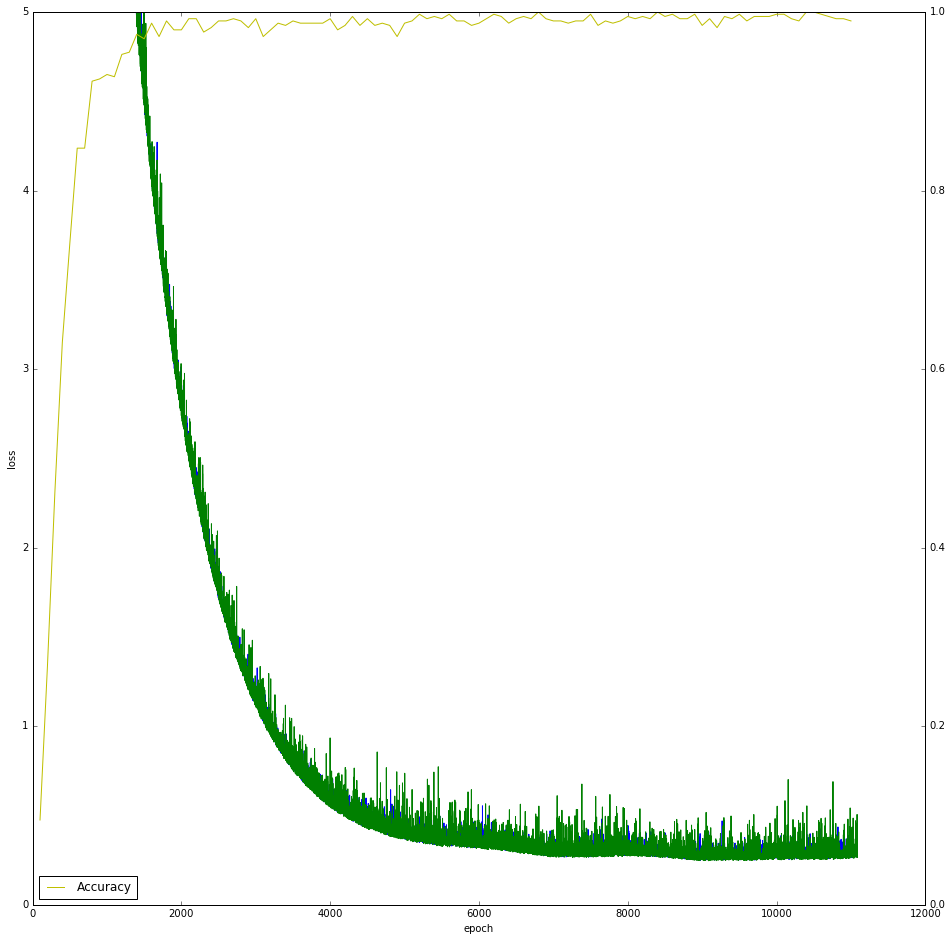

In [25]:
plot_validation_loss(net, validation_file_name, ylim=[0, 5])

Next, please try:
1. Orthogonal weight initialization
2. Compute mean for training set
3. Larger input image
4. Maxout